In [1]:
# 모듈 적용.
import requests
import pprint
import datetime
from dateutil.relativedelta import relativedelta
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import csv
import time
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support.select import Select


import webdriver_manager
from webdriver_manager.chrome import ChromeDriverManager

print(selenium.__version__)
print(webdriver_manager.__version__)


font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()

plt.rcParams["font.family"] = font_family
plt.rcParams["axes.unicode_minus"] = False


%matplotlib inline

4.9.0
3.8.6


### 감염자 현황 받아오기

In [4]:
# 두개를 합치기
# 루프 시작 값
url = 'http://apis.data.go.kr/1352000/ODMS_COVID_02/callCovid02Api'
# key = '발급 키를 여기에 입력'
dt = '20200120'
test_list = ['0']
dt_time = datetime.datetime(2020, 2, 1)

# 20230301 완료날자
while dt != '20230301':
    dt_key = dt_time.strftime('%Y년 %m월')
    dt = dt_time.strftime('%Y%m%d')
    
    param ={'serviceKey' : key, 'pageNo' : '1', 'numOfRows' : '500', 'apiType' : 'xml', 'status_dt' : dt }
    
    while True:
        try:
            res = requests.get(url, params=param)
            break
        except requests.exceptions.ConnectionError:
            print('Connection Error occurred. Retrying in 5 seconds...')
            time.sleep(5)
            
    # gpt로 만든 xml데이터 가져오기
    root = ET.fromstring(res.content)

    # 모든 item 요소 가져오기
    items = root.findall(".//item")

    # 첫 번째 item 요소 선택
    item = items[0]
    
    # statusDt와 hPntCnt 값을 가져오기
    hPntCnt = item.findtext("hPntCnt")
    test_list.append(hPntCnt)

    dt_time = dt_time + relativedelta(months=1)

Connection Error occurred. Retrying in 5 seconds...
Connection Error occurred. Retrying in 5 seconds...


### 시계열 데이터와 결합시켜 DataFrame만들기

In [5]:
data = {}
month = []
data_list = []
dt_time = datetime.datetime(2020, 1, 1)
for i in range(len(test_list)-1):
    month.append(dt_time.strftime('%Y년 %m월'))
    data_list.append(int(test_list[i+1]) - int(test_list[i]))
    dt_time = dt_time + relativedelta(months=1)
    
data['기간명'] = month
data['확진자 수'] = data_list

In [6]:
# API로 받아온 데이터 저장하기
with open('확진자_수.csv', 'w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in data.items():
        writer.writerow([key, value])

In [7]:
df = pd.DataFrame(data)
df = df.reset_index()
df = df.set_index('기간명')
df = df.drop('index',axis=1)
df

,확진자 수
기간명,
2020년 01월,12
2020년 02월,3514
2020년 03월,6361
2020년 04월,887
2020년 05월,729
2020년 06월,1347
2020년 07월,1486
2020년 08월,5845
2020년 09월,3707


### 엑셀 데이터 받아오기
굉장히 오래걸릴수 있음.

In [8]:
service = ChromeService(executable_path=ChromeDriverManager().install())
options = Options()
# 크롬을 숨기기
options.add_argument("--headless")
# 데이터를 많이 요청할경우 agent라는걸 알려주는 메시지를 보냄
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36")
driver = webdriver.Chrome(service=service, options=options)

driver.get("http://opendata.hira.or.kr/op/opc/olapMsupInfo.do")
driver.set_window_size(974, 1040)
links = ["약국 직접/처방 조제","약효분류별"]
for j in links:
    # 처방, 약효 선택
    driver.find_element(By.LINK_TEXT, j).click()
    driver.switch_to.frame(driver.find_element(By.CSS_SELECTOR, "div.olap-box > iframe"))
    driver.implicitly_wait(60)

    for i in range(10, 20, 3):
        # 시작 년/월 선택하기
        # 표 띄우기
        driver.find_element(By.CSS_SELECTOR, "table > tbody > tr > td > div:nth-child(4) > div > input:nth-child(2)").click()
        # 년도 선택
        dropdown = driver.find_elements(By.CSS_SELECTOR, "div.ui-datepicker-header.ui-widget-header.ui-helper-clearfix.ui-corner-all.mtz-monthpicker")
        dropdown[0].find_element(By.XPATH, f"//option[. = '20{i}']").click()
        # 월 선택
        driver.find_element(By.CSS_SELECTOR, "table.mtz-monthpicker tbody tr:nth-of-type(1) td:nth-of-type(1)").click()

        # 끝 년/월 선택하기
        # 표 띄우기
        driver.find_element(By.CSS_SELECTOR, "table > tbody > tr > td > div:nth-child(4) > div > input:nth-child(4)").click()
        # 년도 선택
        elements = driver.find_elements(By.CSS_SELECTOR, ".mtz-monthpicker.mtz-monthpicker-year")
        select = Select(elements[1])
        select.select_by_visible_text(f"20{i+2}")
        # 월 선택
        table = driver.find_elements(By.CSS_SELECTOR, 'table.mtz-monthpicker')[-1]
        december = WebDriverWait(table, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'td[data-month="12"]')))
        december.click()
        
        # 조회버튼 누르기
        driver.find_element(By.CSS_SELECTOR, "#ext-gen1316 > table > tbody > tr > td > div.dt-btn-search > span").click()
        time.sleep(90)
        # 엑셀 다운받기
        driver.find_element(By.CSS_SELECTOR, "#panel-1023-body > div:nth-child(8) > div.dock_inner > div.dock_title.doc_title_selected.mec-report-titlebar > div.dock_title_btnarea > div.dock_button.dock_exp_excel_button").click()
        driver.implicitly_wait(30)
    
    # 2022~2023년도 데이터 받기
    driver.find_element(By.CSS_SELECTOR, "table > tbody > tr > td > div:nth-child(4) > div > input:nth-child(2)").click()
    dropdown = driver.find_elements(By.CSS_SELECTOR, "div.ui-datepicker-header.ui-widget-header.ui-helper-clearfix.ui-corner-all.mtz-monthpicker")
    dropdown[0].find_element(By.XPATH, f"//option[. = '2022']").click()
    driver.find_element(By.CSS_SELECTOR, "table.mtz-monthpicker tbody tr:nth-of-type(1) td:nth-of-type(1)").click()


    driver.find_element(By.CSS_SELECTOR, "table > tbody > tr > td > div:nth-child(4) > div > input:nth-child(4)").click()
    elements = driver.find_elements(By.CSS_SELECTOR, ".mtz-monthpicker.mtz-monthpicker-year")
    select = Select(elements[1])
    select.select_by_visible_text(f"2023")

    table = driver.find_elements(By.CSS_SELECTOR, 'table.mtz-monthpicker')[-1]
    december = WebDriverWait(table, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'td[data-month="12"]')))
    december.click()

    driver.find_element(By.CSS_SELECTOR, "#ext-gen1316 > table > tbody > tr > td > div.dt-btn-search > span").click()
    time.sleep(90)
    driver.find_element(By.CSS_SELECTOR, "#panel-1023-body > div:nth-child(8) > div.dock_inner > div.dock_title.doc_title_selected.mec-report-titlebar > div.dock_title_btnarea > div.dock_button.dock_exp_excel_button").click()

driver.close()
driver.quit()

### 엑셀 데이터 데이터프레임에 적용하기
1. 처방조제수

In [2]:
# 인덱스와 컬럼을 담을 리스트 생성
main_index = []
sub_index = []
colum_1 = []
colum_2 = []

# 파일을 불러와 리스트에 담음
for i in range(10,23,3):
    # 파일 번호가 다른것을 이용해 루프 만들기
    file_number = 2000 + i
    file_path = f'.\data\처방조제수_{file_number}.xls'
    
    # 판다스로 엑셀 불러오기
    data = pd.read_excel(file_path, header=None)
    
    # 엑셀의 행에서 인덱스값과 컬럼값을 리스트에 저장하기.
    row_data = data.iloc[6]
    main_index.append(row_data.drop(0).values)
    row_data = data.iloc[7]
    sub_index.append(row_data.drop(0).values)
    row_data = data.iloc[8]
    colum_1.append(row_data.drop(0).values)
    row_data = data.iloc[9]
    colum_2.append(row_data.drop(0).values)

# 리스트에 저장한 데이터를 하나의 데이터로 평탄화해줌
main_index = np.concatenate(main_index)
sub_index = np.concatenate(sub_index)
colum_1 = np.concatenate(colum_1)
colum_2 = np.concatenate(colum_2)

# 인덱스는 인덱스끼리, 컬럼은 컬럼끼리 묶어줌.
arrays1 = [main_index,sub_index]
arrays2 = [colum_1,colum_2]

# 각 인덱스와 컬럼을 zip으로 묶어줌
tuples = list(zip(*arrays1))
data_tuples = list(zip(*arrays2))

# 인덱스와 칼럼을 멀티플인덱스에 할당해줌.
index = pd.MultiIndex.from_tuples(tuples)
columns = pd.MultiIndex.from_tuples([('직접조제', '천명','천개','백만원'), ('처방조제', '천명','천개','백만원')])

# 데이터프레임으로 데이터를 불러옴
df2 = pd.DataFrame(data_tuples, index=index, columns=columns)
df2

직접조제       처방조제
                   천명         천명
                   천개         천개
                  백만원        백만원
2010년 01월 환자수      88     18,439
          수량    5,052  3,146,476
          사용금액    342    748,611
2010년 02월 환자수      77     17,620
          수량    4,274  2,972,166
...               ...        ...
2022년 07월 수량    2,865  4,282,261
          사용금액    239  1,499,369
2022년 08월 환자수      68     23,651
          수량    3,651  4,522,492
          사용금액    297  1,583,288

[456 rows x 2 columns]

2. 약효분류별 빈도

In [3]:
main_index = []
sub_index = []
colum_1 = []
colum_2 = []
for i in range(10,23,3):
    file_number = 2000 + i
    file_path = f'.\data\약효분류별_빈도_{file_number}.xls'
    data = pd.read_excel(file_path, header=None)
    row_data = data.iloc[6]
    main_index.append(row_data.drop(index=[0, 1]).values)
    row_data = data.iloc[7]
    sub_index.append(row_data.drop(index=[0, 1]).values)
    row_data = data.iloc[12]
    colum_1.append(row_data.drop(index=[0, 1]).values)
    row_data = data.iloc[39]
    colum_2.append(row_data.drop(index=[0, 1]).values)

main_index = np.concatenate(main_index)
sub_index = np.concatenate(sub_index)
colum_1 = np.concatenate(colum_1)
colum_2 = np.concatenate(colum_2)

arrays1 = [main_index,sub_index]
arrays2 = [colum_1,colum_2]
tuples = list(zip(*arrays1))
data_tuples = list(zip(*arrays2))
index = pd.MultiIndex.from_tuples(tuples)
columns = pd.MultiIndex.from_tuples([('해열·진통·소염제','천개','백만원'), ('진해거담제','천개','백만원')])
df3 = pd.DataFrame(data_tuples, index=index, columns=columns)
df3

해열·진통·소염제    진해거담제
                      천개       천개
                     백만원      백만원
2010년 01월 수량     320,654   22,280
          사용금액    53,920    4,273
2010년 02월 수량     295,984   21,629
          사용금액    49,287    3,815
2010년 03월 수량     377,163   29,309
...                  ...      ...
2022년 12월 사용금액    20,254   57,332
2023년 01월 수량      38,845  354,922
          사용금액     8,443   35,994
2023년 02월 수량         414    3,491
          사용금액        94      305

[316 rows x 2 columns]

### data에 있는 ,를 제거 후 int로 변환해줌

In [4]:
df2 = df2.astype(str).apply(lambda x: x.str.replace(',', '')).astype(int)
df2 = df2.astype(int)
df3 = df3.astype(str).apply(lambda x: x.str.replace(',', '')).astype(int)
df3 = df3.astype(int)

### 총 환자수, 총 판매량 컬럼을 만들어줌.

In [5]:
df2['총 환자수'] = df2.sum(axis=1)
df3['총 판매량'] = df3.sum(axis=1)

In [20]:
dfcsv1 = df2['총 환자수'].xs('환자수', level=1)
dfcsv1 = pd.DataFrame(dfcsv1)
dfcsv1

,총 환자수
2010년 01월,18527
2010년 02월,17697
2010년 03월,20363
2010년 04월,21273
2010년 05월,19984
...,...
2022년 04월,23718
2022년 05월,22091
2022년 06월,21167
2022년 07월,22572


In [21]:
dfcsv2 = df3['총 판매량'].xs('수량', level=1)
dfcsv2 = pd.DataFrame(dfcsv2)
dfcsv2

,총 판매량
2010년 01월,342934
2010년 02월,317613
2010년 03월,406472
2010년 04월,494260
2010년 05월,425514
...,...
2022년 10월,505314
2022년 11월,553444
2022년 12월,647947
2023년 01월,393767


In [31]:
result = pd.concat([dfcsv1, dfcsv2], axis=1, join='inner')
result.to_csv('환자수_의약품판매량.csv', index=False)

### 코로나 이전(2019년 12월)데이터와 이후 데이터로 나눠줌
1. 이전 데이터 전처리

In [13]:
# 코로나 이전 데이터
df2_pre = df2.loc[:'2019년 12월',:]['총 환자수'].xs('환자수', level=1)
df3_pre = df3.loc[:'2019년 12월', :]['총 판매량'].xs('수량', level=1)

In [39]:
# 코로나 이전 월별 총 환자 수, 총 판매량
mean_list = []
month_list = []
mean_list2 = []
for i in range(1,13):
    data_mean = 0
    data_mean_2 = 0
    for j in range(10):
        data_mean += df2_pre.loc[f'201{j}년 {i:02d}월']
        data_mean_2 += df3_pre.loc[f'201{j}년 {i:02d}월']
    month_list.append(f'{i:02d}월')
    mean_list.append(int(data_mean/10))
    mean_list2.append(int(data_mean_2/10))

### 코로나 이전 평균 데이터

In [40]:
Pre_average = pd.DataFrame({'환자수': mean_list, '판매량' : mean_list2}, index=month_list)
Pre_average

,환자수,판매량
01월,21127,833305
02월,20161,727589
03월,21665,782727
04월,21811,788207
05월,21239,746458
06월,19908,650498
07월,19947,638231
08월,20053,626881
09월,21225,676878
10월,21458,694504


2. 이후 데이터 전처리

In [41]:
# 년단위로 데이터 쪼개기
df2_post_2020 = df2.loc['2020년 01월':'2020년 12월',:]['총 환자수'].xs('환자수', level=1)
df2_post_2021 = df2.loc['2021년 01월':'2021년 12월',:]['총 환자수'].xs('환자수', level=1)
df2_post_2022 = df2.loc['2022년 01월':'2022년 12월',:]['총 환자수'].xs('환자수', level=1)

In [42]:
# 년단위로 데이터 쪼개기
df3_post_2020 = df3.loc['2020년 01월':'2020년 12월',:]['총 판매량'].xs('수량', level=1)
df3_post_2021 = df3.loc['2021년 01월':'2021년 12월',:]['총 판매량'].xs('수량', level=1)
df3_post_2022 = df3.loc['2022년 01월':'2022년 12월',:]['총 판매량'].xs('수량', level=1)
df3_post_2023 = df3.loc['2023년 01월':'2023년 12월',:]['총 판매량'].xs('수량', level=1)

In [43]:
# 이상값 제거하기
df3_post_2023 = df3_post_2023.iloc[:-1]

In [44]:
# 월 평균값을 빼서 차이값 구하기
df2_2020_val = df2_post_2020.values - Pre_average['환자수'].values
df2_2021_val = df2_post_2021.values - Pre_average['환자수'].values
df2_2022_val = df2_post_2022.values - Pre_average['환자수'][:len(df2_post_2022)].values
df2_post = np.concatenate((df2_2020_val, df2_2021_val, df2_2022_val))

In [45]:
# 월 평균값을 빼서 차이값 구하기
df3_2020_val = df3_post_2020.values - Pre_average['판매량'].values
df3_2021_val = df3_post_2021.values - Pre_average['판매량'].values
df3_2022_val = df3_post_2022.values - Pre_average['판매량'].values
df3_2023_val = df3_post_2023.values - Pre_average['판매량'][:len(df3_post_2023)].values
df3_post = np.concatenate((df3_2020_val, df3_2021_val, df3_2022_val, df3_2023_val))

In [46]:
# 두 배열의 길이 비교
diff = len(df2_post) - len(df3_post)

# 두 배열 중 더 긴 길이 구하기
max_length = max(len(df2_post), len(df3_post))

# 더 짧은 배열의 끝 부분에 0 추가
if diff > 0:
    df3_post = np.pad(df3_post, (0, diff), mode='constant', constant_values=0)
else:
    df2_post = np.pad(df2_post, (0, abs(diff)), mode='constant', constant_values=0)

In [47]:
post_index = df3.loc['2020년 01월':'2023년 01월',:]['총 판매량'].xs('수량', level=1).index.tolist()

### 코로나 이후 데이터

In [48]:
post_average = pd.DataFrame({'환자수': df2_post, '판매량': df3_post}, index = post_index)
post_average = post_average.rename_axis('기간명')
post_average

,환자수,판매량
기간명,,
2020년 01월,2422,313639
2020년 02월,-131,84729
2020년 03월,-3467,62052
2020년 04월,-3654,8586
2020년 05월,-1595,105508
2020년 06월,239,201442
2020년 07월,260,231878
2020년 08월,-679,204188
2020년 09월,-1310,158134


### 두 데이터 비교하기

In [49]:
df_final = pd.merge(post_average, df, on='기간명')
df_final

,환자수,판매량,확진자 수
기간명,,,
2020년 01월,2422,313639,12
2020년 02월,-131,84729,3514
2020년 03월,-3467,62052,6361
2020년 04월,-3654,8586,887
2020년 05월,-1595,105508,729
2020년 06월,239,201442,1347
2020년 07월,260,231878,1486
2020년 08월,-679,204188,5845
2020년 09월,-1310,158134,3707


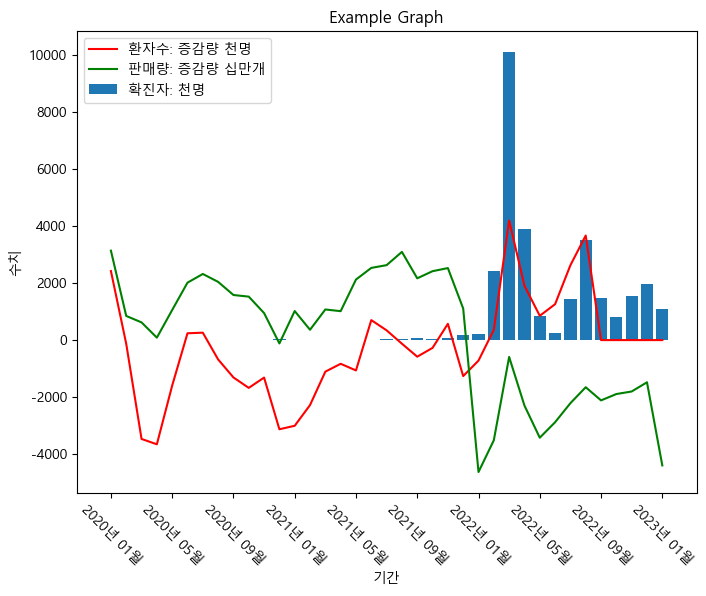

In [50]:
# 선그래프와 바그래프를 그립니다.
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df_final.index, df_final['환자수'], label='환자수: 증감량 천명',color='red')
ax.plot(df_final.index, df_final['판매량']/100, label='판매량: 증감량 십만개',color='green')
ax.bar(df_final.index, df_final['확진자 수']/1000, label='확진자: 천명')

# 그래프 제목, 축 레이블, 범례 등을 추가합니다.
ax.set_title('Example Graph')
ax.set_xlabel('기간')
ax.set_ylabel('수치')
ax.legend()
ax.yaxis.get_major_formatter().set_scientific(False)

# x축 틱 형식 변경 (4달 간격)
locator = mdates.MonthLocator(interval=4)
ax.xaxis.set_major_locator(locator)

# 4달 간격으로 틱 라벨 표시
ax.xaxis.set_major_locator(ticker.MultipleLocator(4))

for label in ax.xaxis.get_ticklabels():
    label.set_rotation(315)

plt.show()